# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm, t
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import defaultdict
if "axion" in plt.style.available:
    print("Using custom mplstyle")
    plt.style.use("axion")
from ols_violations.violations.autocorrelation import generate_ar1_errors, generate_iid_errors
from ols_violations.utils import SimulationParams

from pathlib import Path
for parent in Path(".").absolute().parents:
    if (parent / ".git").exists():
        OUT_PATH = parent / "src/broken-assumptions/figs/autocorrelation"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using custom mplstyle


# 1) Example Data

Generate data with 
+ no autocorrelation (white noise)
+ positive autocorrelation
+ negative autocorrelation

In all cases the residual variance $\mathrm{Var}(\epsilon_t)$ is constant. 
That is, 
$$
\mathrm{Var}(\epsilon_t^\mathrm{WN}) = \mathrm{Var}(\epsilon_t^\mathrm{+AR1}) = \mathrm{Var}(\epsilon_t^\mathrm{-AR1}) .
$$

The AR1 processes are generated via $\varepsilon_t = \rho \varepsilon_{t-1} + u_t$, where $u_t$ are iid samples from $N(0, \sigma^2)$.
Therefore, we have $\mathrm{Var}(\epsilon_t^\mathrm{+AR1}) = \mathrm{Var}(\epsilon_t^\mathrm{-AR1}) = \sigma^2 / (1 - \rho^2)$.
To make the variances match we sample $\epsilon_t^\mathrm{WN}$ from $N(0, \sigma^2 / (1 - \rho^2))$.

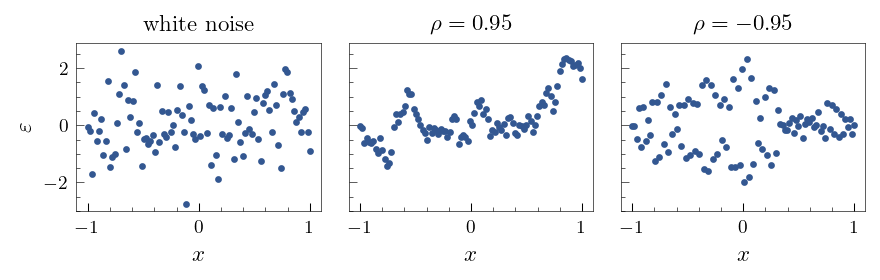

In [15]:
%matplotlib inline

params = SimulationParams(
    n_simulations=1,
    n_samples=100,
    beta=0.0,  # True coefficient
    alpha=0.0,  # True intercept
    rho=0.95,  # High autocorrelation
    sigma=0.3,  # Noise level
    seed=93530,
)

# Residuals
et_iid = generate_iid_errors(params).ravel()
et_ar1_pos = generate_ar1_errors(params).ravel()
params.rho = - abs(params.rho)
et_ar1_neg = generate_ar1_errors(params).ravel()

# Feature "X"
xt = np.linspace(-1, 1, params.n_samples)

fig, ax = plt.subplots(1, 3, figsize=(6,2), sharey=True)
ax[0].scatter(xt, et_iid, s=5)
ax[1].scatter(xt, et_ar1_pos, s=5)
ax[2].scatter(xt, et_ar1_neg, s=5)
ax[0].set_ylabel("$\\varepsilon$")

titles = [f'white noise', f'$\\rho = {abs(params.rho)}$', f'$\\rho = {-abs(params.rho)}$']
for i, title in zip(range(3), titles):
    ax[i].set_xlabel("$x$")
    ax[i].set_title(title)
plt.tight_layout()
plt.savefig(str(OUT_PATH / "example_data.png"), bbox_inches='tight')

# 2) Distribution of $\hat{\beta}_\mathrm{OLS}$

In [16]:
params = SimulationParams(
    n_simulations=10000,
    n_samples=100,
    beta=0.0,  # True coefficient
    alpha=0.0,  # True intercept
    rho=0.7,  # High autocorrelation
    sigma=0.3,  # Noise level
)

# Feature "X"
xt = np.linspace(-1, 1, params.n_samples)
X = sm.add_constant(xt)

labels = ["wn", "ar1+", "ar1-"]
results = {}
def generate_ar1_errors_neg(params): 
    _params = SimulationParams(**dict(params))
    _params.rho = - abs(params.rho)
    return generate_ar1_errors(_params)
generators = [generate_iid_errors, generate_ar1_errors, generate_ar1_errors_neg]

for label, generator in zip(labels, generators):
    # Residuals
    et = generator(params)

    beta_ols_vals = []
    t_vals = []
    for i in tqdm(range(params.n_simulations)):

        yt = et[i]
        mdl = sm.OLS(yt, X).fit()
        resid = yt - mdl.predict(X)

        df = params.n_samples - len(mdl.params)
        sigma_hat_sq = mdl.ssr / df
        var_beta_ols = sigma_hat_sq  / len(xt) / np.var(xt)
        t_stat = mdl.tvalues[1]

        beta_ols_vals.append(mdl.params[1])
        t_vals.append(t_stat)

    results[label] = {
        "beta_ols_vals" : beta_ols_vals,
        "t_vals" : t_vals,
    }

100%|██████████| 10000/10000 [00:02<00:00, 3922.10it/s]


## Plot $\hat{\beta}_\mathrm{OLS}$ distribution

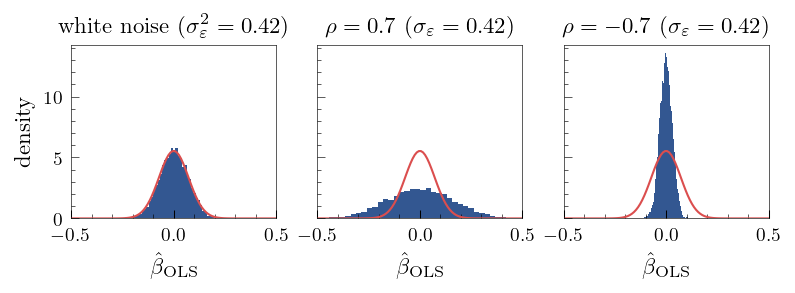

In [17]:
def plot_norm(ax, params, xmin, xmax, **kwargs):
    sigma = np.sqrt(params.sigma**2 / (1 - params.rho**2) / len(xt) / np.var(xt))
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, loc=0, scale=sigma)
    ax.plot(x, y, **kwargs)

sigma_eps = params.sigma / (1 - params.rho**2) ** 0.5
titles = [
    f"white noise ($\\sigma^2_\\varepsilon = {sigma_eps:.2f}$)",
    f"$\\rho = {params.rho}$ ($\\sigma_\\varepsilon = {sigma_eps:.2f}$)",
    f"$\\rho = {-params.rho}$ ($\\sigma_\\varepsilon = {sigma_eps:.2f}$)",
]

fig, ax = plt.subplots(1, 3, figsize=(6, 1.5), sharey=True)
xmin, xmax = -0.5, 0.5
for i, label in enumerate(labels):
    beta_ols_vals = results[label]["beta_ols_vals"]
    ax[i].hist(beta_ols_vals, 50, density=True)
    plot_norm(ax[i], params, xmin=xmin, xmax=xmax)
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_xlabel(r"$\hat{\beta}_\mathrm{OLS}$")
    ax[i].set_title(titles[i])
ax[0].set_ylabel("density")
plt.savefig(str(OUT_PATH / "beta_ols_histogram.png"), bbox_inches='tight')

# 3) t-statistics

In [31]:
def generate_data(params, cov_type='nonrobust'):
    """
    Simulates WN and AR1+, AR1- errors for n_samples = 50, 100, 1000.
    Computes t statistics using standard errors specified by cov_type.
    If cov_type = "HAC" it computes Newey-West standard errors.
    """
    def generate_ar1_errors_neg(params):
        _params = SimulationParams(**dict(params))
        _params.rho = -abs(params.rho)
        return generate_ar1_errors(_params)

    cov_kwds = dict(maxlags=15) if cov_type is not None else None

    results = defaultdict(dict)
    n_samples_vals = [50, 100, 1000]
    for n_samples in n_samples_vals:
        
        params.n_samples = n_samples

        # Feature "X"
        xt = np.linspace(-1, 1, params.n_samples)
        X = sm.add_constant(xt)

        labels = ["wn", "ar1+", "ar1-"]

        generators = [generate_iid_errors, generate_ar1_errors, generate_ar1_errors_neg]

        for label, generator in zip(labels, generators):
            # Residuals
            et = generator(params)
            beta_ols_vals = []
            t_vals = []
            for i in tqdm(range(params.n_simulations)):

                yt = et[i]
                mdl = sm.OLS(yt, X).fit(cov_type=cov_type, cov_kwds=cov_kwds)
                t_stat = mdl.tvalues[1]

                # Append
                beta_ols_vals.append(mdl.params[1])
                t_vals.append(t_stat)

            results[n_samples][label] = {
                "beta_ols_vals": beta_ols_vals,
                "t_vals": t_vals,
            }

    return results

In [ ]:
params = SimulationParams(
    n_simulations=10000,
    n_samples=None, # placeholder
    beta=0.0,  # True coefficient
    alpha=0.0,  # True intercept
    rho=0.7,  # High autocorrelation
    sigma=0.3,  # Noise level
)
results = generate_data(params, cov_type='nonrobust')

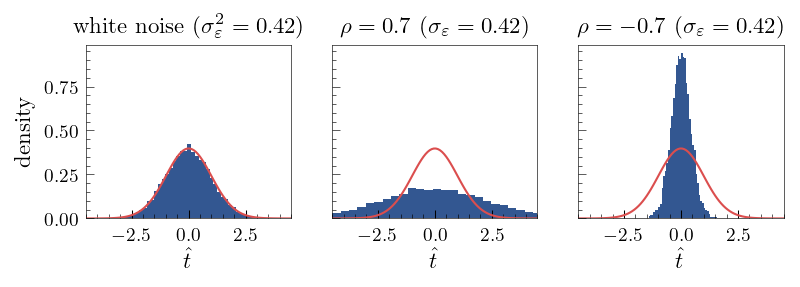

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def plot_norm(ax, params, xmin, xmax, **kwargs):
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x)
    ax.plot(x, y, **kwargs)


# Example variables (replace with your actual values)
n_samples_vals = [50, 100, 1000]
labels = ["wn", "ar1+", "ar1-"]
sigma_eps = params.sigma / (1 - params.rho**2) ** 0.5
titles = [
    f"white noise ($\\sigma^2_\\varepsilon = {sigma_eps:.2f}$)",
    f"$\\rho = {params.rho}$ ($\\sigma_\\varepsilon = {sigma_eps:.2f}$)",
    f"$\\rho = {-params.rho}$ ($\\sigma_\\varepsilon = {sigma_eps:.2f}$)",
]

# Assume results is a dict keyed by n_samples
# and params is defined elsewhere
# For demonstration, we assume they are already defined.

fig, ax = plt.subplots(3, 3, figsize=(6, 3.5), sharey=True, sharex=True)
xmin, xmax = -8, 8

for i, n_samples in enumerate(n_samples_vals):
    for j, label in enumerate(labels):
        t_vals = results[n_samples][label]["t_vals"]
        ax[i, j].hist(t_vals, 100, density=True)
        plot_norm(ax[i, j], params, xmin=xmin, xmax=xmax)
        ax[i, j].set_xlim(xmin, xmax)
        if i == 0:
            ax[i, j].set_title(titles[j])
        if i == 2:
            ax[i, j].set_xlabel(r"$\hat{t}$")
        # if j == 0:
        #     ax[i, j].set_ylabel("density")

# Adjust the layout to make room on the left
plt.subplots_adjust(left=0.15)

# Add a vertical arrow on the left side of the figure.
# (Coordinates are in figure fraction: [0, 1].)
ax[0, 0].annotate(
    "",
    xy=(0.08, 0.8),
    xytext=(0.08, 0.1),
    xycoords="figure fraction",
    arrowprops=dict(arrowstyle="<-", lw=1.0),
)


# Label each row with the corresponding n_samples.
# We choose positions that match the centers of the rows.
fig.text(0.06, 0.85, "$N_\\mathrm{samples}$", ha="center", va="center", fontsize=10)
fig.text(0.02, 0.77, "100", ha="center", va="center", fontsize=10)
fig.text(0.02, 0.50, "500", ha="center", va="center", fontsize=10)
fig.text(0.02, 0.225, "1000", ha="center", va="center", fontsize=10)

plt.savefig(str(OUT_PATH / "t_stats.png"), bbox_inches="tight")

# 4) Newey-West

In [32]:
params = SimulationParams(
    n_simulations=10000,
    n_samples=None, # placeholder
    beta=0.0,  # True coefficient
    alpha=0.0,  # True intercept
    rho=0.7,  # High autocorrelation
    sigma=0.3,  # Noise level
)

results = generate_data(params, cov_type='HAC')

100%|██████████| 10000/10000 [00:04<00:00, 2374.63it/s]


Text(0.02, 0.225, '1000')

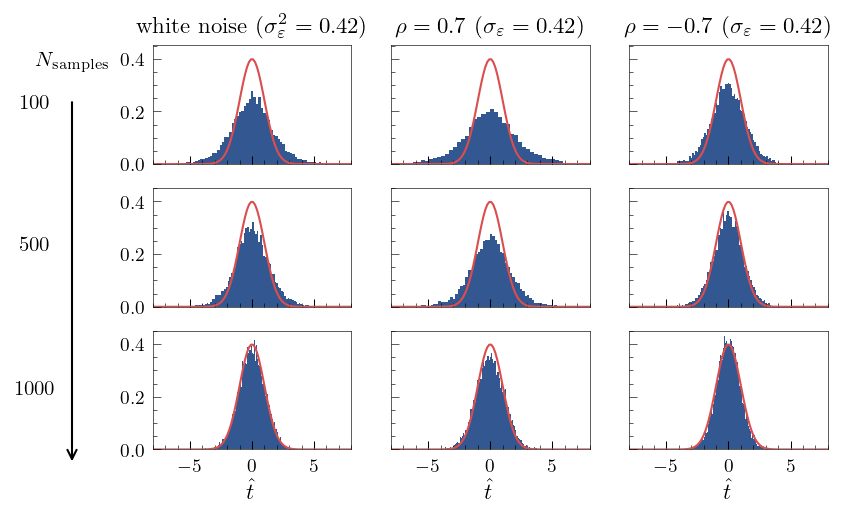

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


def plot_norm(ax, params, xmin, xmax, **kwargs):
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x)
    ax.plot(x, y, **kwargs)


# Example variables (replace with your actual values)
n_samples_vals = [50, 100, 1000]
labels = ["wn", "ar1+", "ar1-"]
sigma_eps = params.sigma / (1 - params.rho**2) ** 0.5
titles = [
    f"white noise ($\\sigma^2_\\varepsilon = {sigma_eps:.2f}$)",
    f"$\\rho = {params.rho}$ ($\\sigma_\\varepsilon = {sigma_eps:.2f}$)",
    f"$\\rho = {-params.rho}$ ($\\sigma_\\varepsilon = {sigma_eps:.2f}$)",
]

# Assume results is a dict keyed by n_samples
# and params is defined elsewhere
# For demonstration, we assume they are already defined.

fig, ax = plt.subplots(3, 3, figsize=(6, 3.5), sharey=True, sharex=True)
xmin, xmax = -8, 8

for i, n_samples in enumerate(n_samples_vals):
    for j, label in enumerate(labels):
        t_vals = results[n_samples][label]["t_vals"]
        ax[i, j].hist(t_vals, 100, density=True)
        plot_norm(ax[i, j], params, xmin=xmin, xmax=xmax)
        ax[i, j].set_xlim(xmin, xmax)
        if i == 0:
            ax[i, j].set_title(titles[j])
        if i == 2:
            ax[i, j].set_xlabel(r"$\hat{t}$")
        # if j == 0:
        #     ax[i, j].set_ylabel("density")

# Adjust the layout to make room on the left
plt.subplots_adjust(left=0.15)

# Add a vertical arrow on the left side of the figure.
# (Coordinates are in figure fraction: [0, 1].)
ax[0, 0].annotate(
    "",
    xy=(0.08, 0.8),
    xytext=(0.08, 0.1),
    xycoords="figure fraction",
    arrowprops=dict(arrowstyle="<-", lw=1.0),
)


# Label each row with the corresponding n_samples.
# We choose positions that match the centers of the rows.
fig.text(0.06, 0.85, "$N_\\mathrm{samples}$", ha="center", va="center", fontsize=10)
fig.text(0.02, 0.77, "100", ha="center", va="center", fontsize=10)
fig.text(0.02, 0.50, "500", ha="center", va="center", fontsize=10)
fig.text(0.02, 0.225, "1000", ha="center", va="center", fontsize=10)

plt.savefig(str(OUT_PATH / "t_stats_NW.png"), bbox_inches="tight")